In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
from IPython.display import display

# Constants
ALL_STARS_DATASET_LOCATION = './datasets/allstar_player_talent.csv'

In [25]:
def get_head_and_tail(dataframe: pd.DataFrame, head: int, tail: int) -> pd.DataFrame:
    """
    Devuelve un pandas DataFrame con las primer X filas (@param head) y las ultimas Y filas (@param tail).

    @param dataframe: Pandas DataFrame con los datos a utilizar.
    @param head: Int con cantidad de filas a utilizar contando desde el principio del dataframe.
    @param tail: Int con cantidad de filas a utilizar contando desde el final del dataframe

    @return: Pandas DataFrame.
    """
    
    return pd.concat([dataframe.head(n=head), dataframe.tail(n=tail)])

In [26]:
def get_na_from_df(dataframe: pd.DataFrame) -> pd.Series:
    """
    Devuelve un pandas Series con la cantidad de filas vacias por cada fila.

    @param dataframe: Pandas DataFrame con los datos a utilizar.

    @return: Pandas Series.
    """
    
    return dataframe.isna().sum()

In [27]:
# Valor default utilizado para nombar el total de columna por groupby.
DEFAULT_COUNT_COLUMN_NAME = 'count'

def get_distinct_values_for_column(dataframe: pd.DataFrame, column: str, 
    count_name=DEFAULT_COUNT_COLUMN_NAME) -> pd.DataFrame:
    
    """
    Devuelve un dataframe agrupado por una columna y con el total de filas para cada uno de los 
    valores de esa columna.

    @param dataframe: Pandas DataFrame con los datos a utilizar.
    @param column: Str con el nombre de la columna por la que desea agrupar.
    @param count_name: Str con el nombre de la columna con el total de filas. El valor
    defualt es DEFAULT_COUNT_COLUMN_NAME.

    @return: Pandas DataFrame
    """

    return dataframe.groupby(by=column).size().reset_index(name='count')

def get_all_group_by_for_each_column(dataframe: pd.DataFrame, columns: List[str], 
    count_name=DEFAULT_COUNT_COLUMN_NAME) -> List[pd.DataFrame]:

    """
    Devuelve una lista de  dataframes agrupados por una columna y con el total de filas para cada uno de los 
    valores de esa columna.

    @param dataframe: Pandas DataFrame con los datos a utilizar.
    @param column: List[Str] con el nombre de cada una de las
    columnas por las que desea agrupar.
    @param count_name: Str con el nombre de la columna con el total de filas. El valor
    defualt es DEFAULT_COUNT_COLUMN_NAME.

    @return: List of Pandas DataFrame
    """

    list_of_dataframes = []
    for column in columns:
        list_of_dataframes.append(get_distinct_values_for_column(
            dataframe=dataframe, column=column, count_name=count_name))
    
    return list_of_dataframes

def draw_bar_chart(dataframe: pd.DataFrame, x_column: str, y_column: str) -> None:
    """
    Devuelve un gráfico de barras usando el Pandas DataFrame pasado.

    @param dataframe: Pandas DataFrame con los datos a utilizar.
    @param x_column: Str con el nombre de la columna a usar en el eje x.
    @param y_column: Str con el nombre de la columna a user en el eje y.

    @return: None
    """
    
    plt.bar(x_column, y_column, data=dataframe)
    plt.xlabel(x_column),
    plt.xticks(rotation = 90)
    plt.ylabel(y_column)
    plt.title('Cantidad de filas por {}'.format(x_column))
    plt.show()

In [28]:
VALID_SUMMARIZATION_OPERATIONS = ['mean', 'median', 'mode']
COLUMNS_COLUMN_NAME_DEFAULT = 'Nombre de columna'

def get_summarization_from_data(
    dataframe: pd.DataFrame, columns: List[str], summarization_op: str,
    valid_operations: List[str] = VALID_SUMMARIZATION_OPERATIONS) -> dict:
    """
    Obtiene la sumarización especificada para las columnas pasadas.

    @param dataframe: Pandas DataFrame con los datos a utilizar.
    @param columns: List str de las columnas a sumarizar.
    @param summarization_op: Str con la operación a realizar
    @param valid_operations: List str con las operaciones validas.

    @return: Diccionario con el resultado de la operación
    utilizando como key el nombre de la columna y como value el resultado.
    """

    if summarization_op not in valid_operations:
        raise ValueError('Invalid operation {}. Valid operations are {}'.format(
            summarization_op, valid_operations))

    return getattr(dataframe[columns], summarization_op)().to_dict()


def create_dataframe_with_each_summarization(
    dataframe: pd.DataFrame, columns: List[str], summarization_ops: List[str], 
    columns_column_name: str = COLUMNS_COLUMN_NAME_DEFAULT) -> pd.DataFrame:
    """
    Obtiene las sumarizaciones especificada para las columnas pasadas.

    @param dataframe: Pandas DataFrame con los datos a utilizar.
    @param columns: List str de las columnas a sumarizar.
    @param summarization_ops: Str con las operaciones a realizar
    @param columns_column_name: Str con el nombre a asignarle a la
    columna con los nombres descriptivos de cada columna procesada.

    @return: Pandas DataFrame con los datos de cada sumarizacion por
    columnas.
    """

    initial_column_name = columns_column_name
    new_df = pd.DataFrame(columns, columns=[initial_column_name])

    for operation in summarization_ops:
        new_df[operation] = new_df[initial_column_name].map(
            get_summarization_from_data(
                dataframe=dataframe, 
                columns=columns, 
                summarization_op=operation
            )
        )
    
    return  new_df

def quantile_value_is_valid(value: float) -> bool:
    """
    Valida que el float pasado sea un valor valido de cuantil.

    @param value: float con el número a validar.

    @return: True si el value es valido, sino False.
    """

    if value > 0 and value < 1:
        return True
    return False

def get_quantile_for_data(dataframe: pd.DataFrame, columns: List[str], quantile: float) -> dict:
    """
    Calcula el cuantil especificado para las columnas pasadas.

    @param dataframe: Pandas DataFrame con los datos a utilizar.
    @param columns: List str de las columnas a utilizar para calcular los cuantiles.   
    @param quantile: float con el valor del cuantil a calcular.

    @return: Diccionario que usa como key el nombre de la columna y como
    value el resultado del calculo del cuantil. 
    """
    
    if not quantile_value_is_valid(value=quantile):
        raise ValueError('Quantile value must be between 0 and 1, passed value: {}'.format(quantile))

    return dataframe[columns].quantile(q=quantile).to_dict()

def create_dataframe_with_quantiles(
    dataframe: pd.DataFrame, columns: List[str], quantiles: List[float],
    columns_column_name: str = COLUMNS_COLUMN_NAME_DEFAULT) -> pd.DataFrame:
    """
    Obtiene los cuantiles especificados para las columnas pasadas.

    @param dataframe: Pandas DataFrame con los datos a utilizar.
    @param columns: List str de las columnas a utilizar para calcular los cuantiles.
    @param quantiles: List float con los cuantiles a calcular.
    @param columns_column_name: Str con el nombre a asignarle a la
    columna con los nombres descriptivos de cada columna procesada.

    @return: Pandas DataFrame con los datos de cada cuantil por
    columnas.
    """

    initial_column_name = columns_column_name
    new_df = pd.DataFrame(columns, columns=[initial_column_name])

    for quantile in quantiles:
        new_df['Quantile {}%'.format(quantile * 100)] = new_df[initial_column_name].map(
            get_quantile_for_data(
                dataframe=dataframe,
                columns=columns,
                quantile=quantile
            )
        )
    
    return new_df


In [29]:
all_stars_df = pd.read_csv(ALL_STARS_DATASET_LOCATION, header=0)

## Resumen del dataset
### Conceptos de Baseball
- **(PA) Plate Appearance**: A un jugador se le atribuye una apariencia de placa cada vez que completa un turno de bateo.
- **(IP) Innings pitched**: Son el número de entradas que ha completado un lanzador, medido por el número de bateadores y corredores de base que se eliminan mientras el lanzador está en el montículo de lanzamiento en un juego.
- **(ASG) All Stars Game**: Partido de All Stars.
- **Carreras ofensivas**: Es una estadística de béisbol que mide la cantidad de carreras que un jugador gano o le costó a su equipo en ofensiva en relación con un jugador promedio
- **Carreras defensivas**: Es una estadística de béisbol que mide la cantidad de carreras que un jugador salvó o le costó a su equipo en defensa en relación con un jugador promedio

### Descripción de cada columna

Columnas del dataset All Players Talent
| Columna  | Descripción  |
|---|---|
| bbref_ID  | ID del jugado basado en [Baseball-Reference.com](https://www.baseball-reference.com/). |
| yearID  | La temporada  |
| gameNum  | Orden del partido dependiendo de la temporada.  |
| gameId  | ID del partido basado en [Baseball-Reference.com](https://www.baseball-reference.com/).   |
| lgID  |  ID de la liga del equipo de All Stars. |
| startingPos  | Posición en la que juego el jugador. [Convención usada.](https://en.wikipedia.org/wiki/Baseball_positions#:~:text=Each%20position%20conventionally%20has%20an,and%209%20(right%20fielder).)  |
| OFF600  | Estimación de talento ofensivo, en carreras por encima del promedio de la liga por cada 600 *PA*. [Link para más información sobre Offensive Stats](https://www.rookieroad.com/baseball/statistics/offensive-stats/). |
| DEF600  | Estimación del talento de fildeo, en carreras por encima del promedio de la liga por cada 600 *PA*. [Link para más información sobre Deffensive Stats](https://www.rookieroad.com/baseball/statistics/defensive-stats/). |
| PITCH200  | Estimación del talento de lanzamiento, en carreras por encima del promedio de la liga por 200 *IP*. [Link para más información sobre Pitcher Stats](https://www.rookieroad.com/baseball/statistics/pitcher-stats/). |
| asg_PA  | Número de PA en el partido.  |
| asg_IP  | Número de IP en el partido.  |
| OFFper9innASG | Carreras ofensivas esperadas añadidas por encima del promedio (de talento) basadas en PA en ASG, escaladas a un juego de 9 entradas  |
| DEFper9innASG | Carreras defensivas esperadas añadidas por encima del promedio (de talento) basadas en PA en ASG, escaladas a un juego de 9 entradas  |
| PITper9innASG | Carreras de lanzamiento esperadas agregadas por encima del promedio (de talento) basadas en IP en ASG, escaladas a un juego de 9 entradas  |
| TOTper9innASG | Carreras esperadas añadidas por encima del promedio (de talento) basadas en PA/IP en ASG, escaladas a un juego de 9 entradas  |

In [30]:
get_head_and_tail(all_stars_df, head=10, tail=10)

,bbref_ID,yearID,gameNum,gameID,lgID,startingPos,OFF600,DEF600,PITCH200,asg_PA,asg_IP,OFFper9innASG,DEFper9innASG,PITper9innASG,TOTper9innASG
0,goldspa01,2015,0,NLS201507140,NL,3.0,36.755724,-0.117214,0.000000,3,0.0,0.183779,-0.000586,0.000000,0.183193
1,mccutan01,2015,0,NLS201507140,NL,8.0,33.676168,-0.168658,0.000000,3,0.0,0.168381,-0.000843,0.000000,0.167538
2,harpebr03,2015,0,NLS201507140,NL,9.0,30.925454,1.382969,0.000000,3,0.0,0.154627,0.006915,0.000000,0.161542
3,greinza01,2015,0,NLS201507140,NL,1.0,0.000000,0.000000,15.645611,0,2.0,0.000000,0.000000,0.156456,0.156456
4,poseybu01,2015,0,NLS201507140,NL,2.0,21.692969,7.595546,0.000000,2,0.0,0.072310,0.025318,0.000000,0.097628
5,frazito01,2015,0,NLS201507140,NL,5.0,14.534261,4.787243,0.000000,3,0.0,0.072671,0.023936,0.000000,0.096608
6,rizzoan01,2015,0,NLS201507140,NL,0.0,22.171148,0.670665,0.000000,2,0.0,0.073904,0.002236,0.000000,0.076139
7,kershcl01,2015,0,NLS201507140,NL,NaN,0.000000,0.000000,14.695875,0,1.0,0.000000,0.000000,0.073479,0.073479
8,peraljh01,2015,0,NLS201507140,NL,6.0,7.193126,10.385048,0.000000,2,0.0,0.023977,0.034617,0.000000,0.058594
9,crawfbr01,2015,0,NLS201507140,NL,NaN,2.372143,13.079626,0.000000,2,0.0,0.007907,0.043599,0.000000,0.051506


### Cantidad de nulos por columna

In [31]:
get_na_from_df(dataframe=all_stars_df)

bbref_ID            0
yearID              0
gameNum             0
gameID              0
lgID                0
startingPos      2351
OFF600              0
DEF600              0
PITCH200            0
asg_PA              0
asg_IP              0
OFFper9innASG       0
DEFper9innASG       0
PITper9innASG       0
TOTper9innASG       0
dtype: int64

## Análisis de variables cualitativas
### Columnas con variables cualitativas

- yearID
- gameNum 
- gameID 
- lgID
- startingPos

yearID


,yearID,count
0,1933,30
1,1934,35
2,1935,31
3,1936,31
4,1937,31
...,...,...
77,2011,60
78,2012,61
79,2013,55
80,2014,62


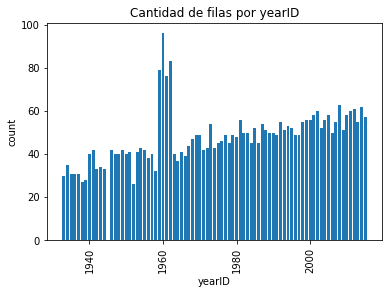

gameNum


,gameNum,count
0,0,3596
1,1,169
2,2,165


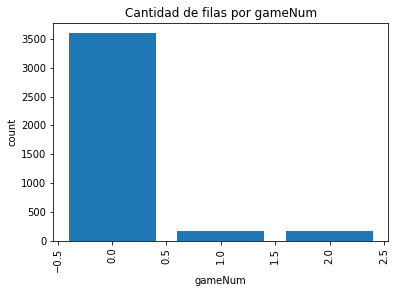

lgID


,lgID,count
0,AL,1931
1,NL,1999


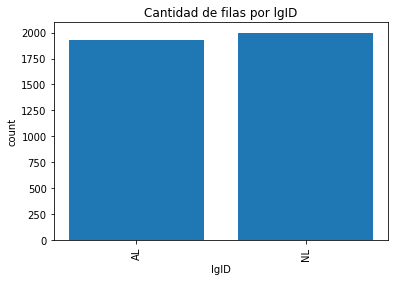

startingPos


,startingPos,count
0,0.0,10
1,1.0,172
2,2.0,172
3,3.0,172
4,4.0,172
5,5.0,172
6,6.0,171
7,7.0,172
8,8.0,172
9,9.0,172


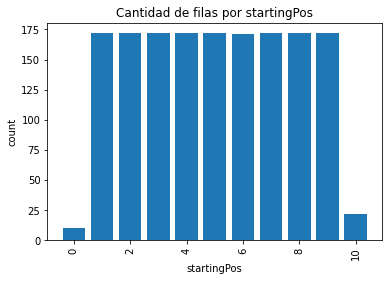

In [32]:
list_of_qualitative_columns = ['yearID', 'gameNum', 'lgID', 'startingPos']

group_by_dfs = get_all_group_by_for_each_column(dataframe=all_stars_df, columns=list_of_qualitative_columns)

for column, df in zip(list_of_qualitative_columns, group_by_dfs):
    print(column)
    display(df)
    draw_bar_chart(dataframe=df, x_column=column, y_column=DEFAULT_COUNT_COLUMN_NAME)

### ¿Es posible realizar este gráfico con un histograma?

## Análisis de variables cuantitatuvas
### Columnas con variables cuantitativas

- OFF600
- DEF600 
- PITCH200 
- asg_PA
- asg_IP
- OFFper9innASG
- DEFper9innASG
- PITper9innASG
- TOTper9innASG

In [33]:
list_of_quantitative_columns = ['OFF600', 'DEF600', 'PITCH200', 'asg_PA', 'asg_IP', 'OFFper9innASG', 'DEFper9innASG', 'PITper9innASG', 'TOTper9innASG']
summarization_operations = ['mean', 'median', 'mode']


summarized_df = create_dataframe_with_each_summarization(
    dataframe=all_stars_df,
    columns=list_of_quantitative_columns,
    summarization_ops=summarization_operations)

quantiles_df = create_dataframe_with_quantiles(
    dataframe=all_stars_df, 
    columns=list_of_quantitative_columns, 
    quantiles=[0.25, 0.75])

pd.merge(left=summarized_df, right=quantiles_df, left_on='Nombre de columna', right_on='Nombre de columna')


,Nombre de columna,mean,median,mode,Quantile 25.0%,Quantile 75.0%
0,OFF600,10.268185,7.192174,{0: 0.0},0.000000,18.889090
1,DEF600,0.925774,0.000000,{0: 0.0},-2.758707,4.507549
2,PITCH200,2.142385,0.000000,{0: 0.0},0.000000,0.000000
3,asg_PA,1.620611,1.000000,{0: 0},0.000000,3.000000
4,asg_IP,0.397625,0.000000,{0: 0.0},0.000000,0.333000
5,OFFper9innASG,0.042923,0.015812,{0: 0.0},0.000000,0.064107
6,DEFper9innASG,0.003909,0.000000,{0: 0.0},-0.007235,0.012266
7,PITper9innASG,0.016541,0.000000,{0: 0.0},0.000000,0.000000
8,TOTper9innASG,0.063373,0.041353,{0: 0.0},0.012496,0.090574


## Correlación de las variables

In [42]:
all_stars_only_quantitative_variables = all_stars_df[list_of_quantitative_columns]
all_stars_only_quantitative_variables.corr(method='pearson')



,OFF600,DEF600,PITCH200,asg_PA,asg_IP,OFFper9innASG,DEFper9innASG,PITper9innASG,TOTper9innASG
OFF600,1.000000,-0.256360,-0.329470,0.486650,-0.362290,0.863510,-0.188872,-0.271961,0.581743
DEF600,-0.256360,1.000000,-0.060090,0.088480,-0.066076,-0.144782,0.873299,-0.049601,0.146895
PITCH200,-0.329470,-0.060090,1.000000,-0.504225,0.647027,-0.270136,-0.064560,0.856499,0.222916
asg_PA,0.486650,0.088480,-0.504225,1.000000,-0.554508,0.639115,0.172013,-0.416254,0.416545
asg_IP,-0.362290,-0.066076,0.647027,-0.554508,1.000000,-0.297045,-0.070991,0.754566,0.136143
OFFper9innASG,0.863510,-0.144782,-0.270136,0.639115,-0.297045,1.000000,-0.112499,-0.222984,0.765062
DEFper9innASG,-0.188872,0.873299,-0.064560,0.172013,-0.070991,-0.112499,1.000000,-0.053291,0.220069
PITper9innASG,-0.271961,-0.049601,0.856499,-0.416254,0.754566,-0.222984,-0.053291,1.000000,0.354529
TOTper9innASG,0.581743,0.146895,0.222916,0.416545,0.136143,0.765062,0.220069,0.354529,1.000000


## Scatterploat Matrix

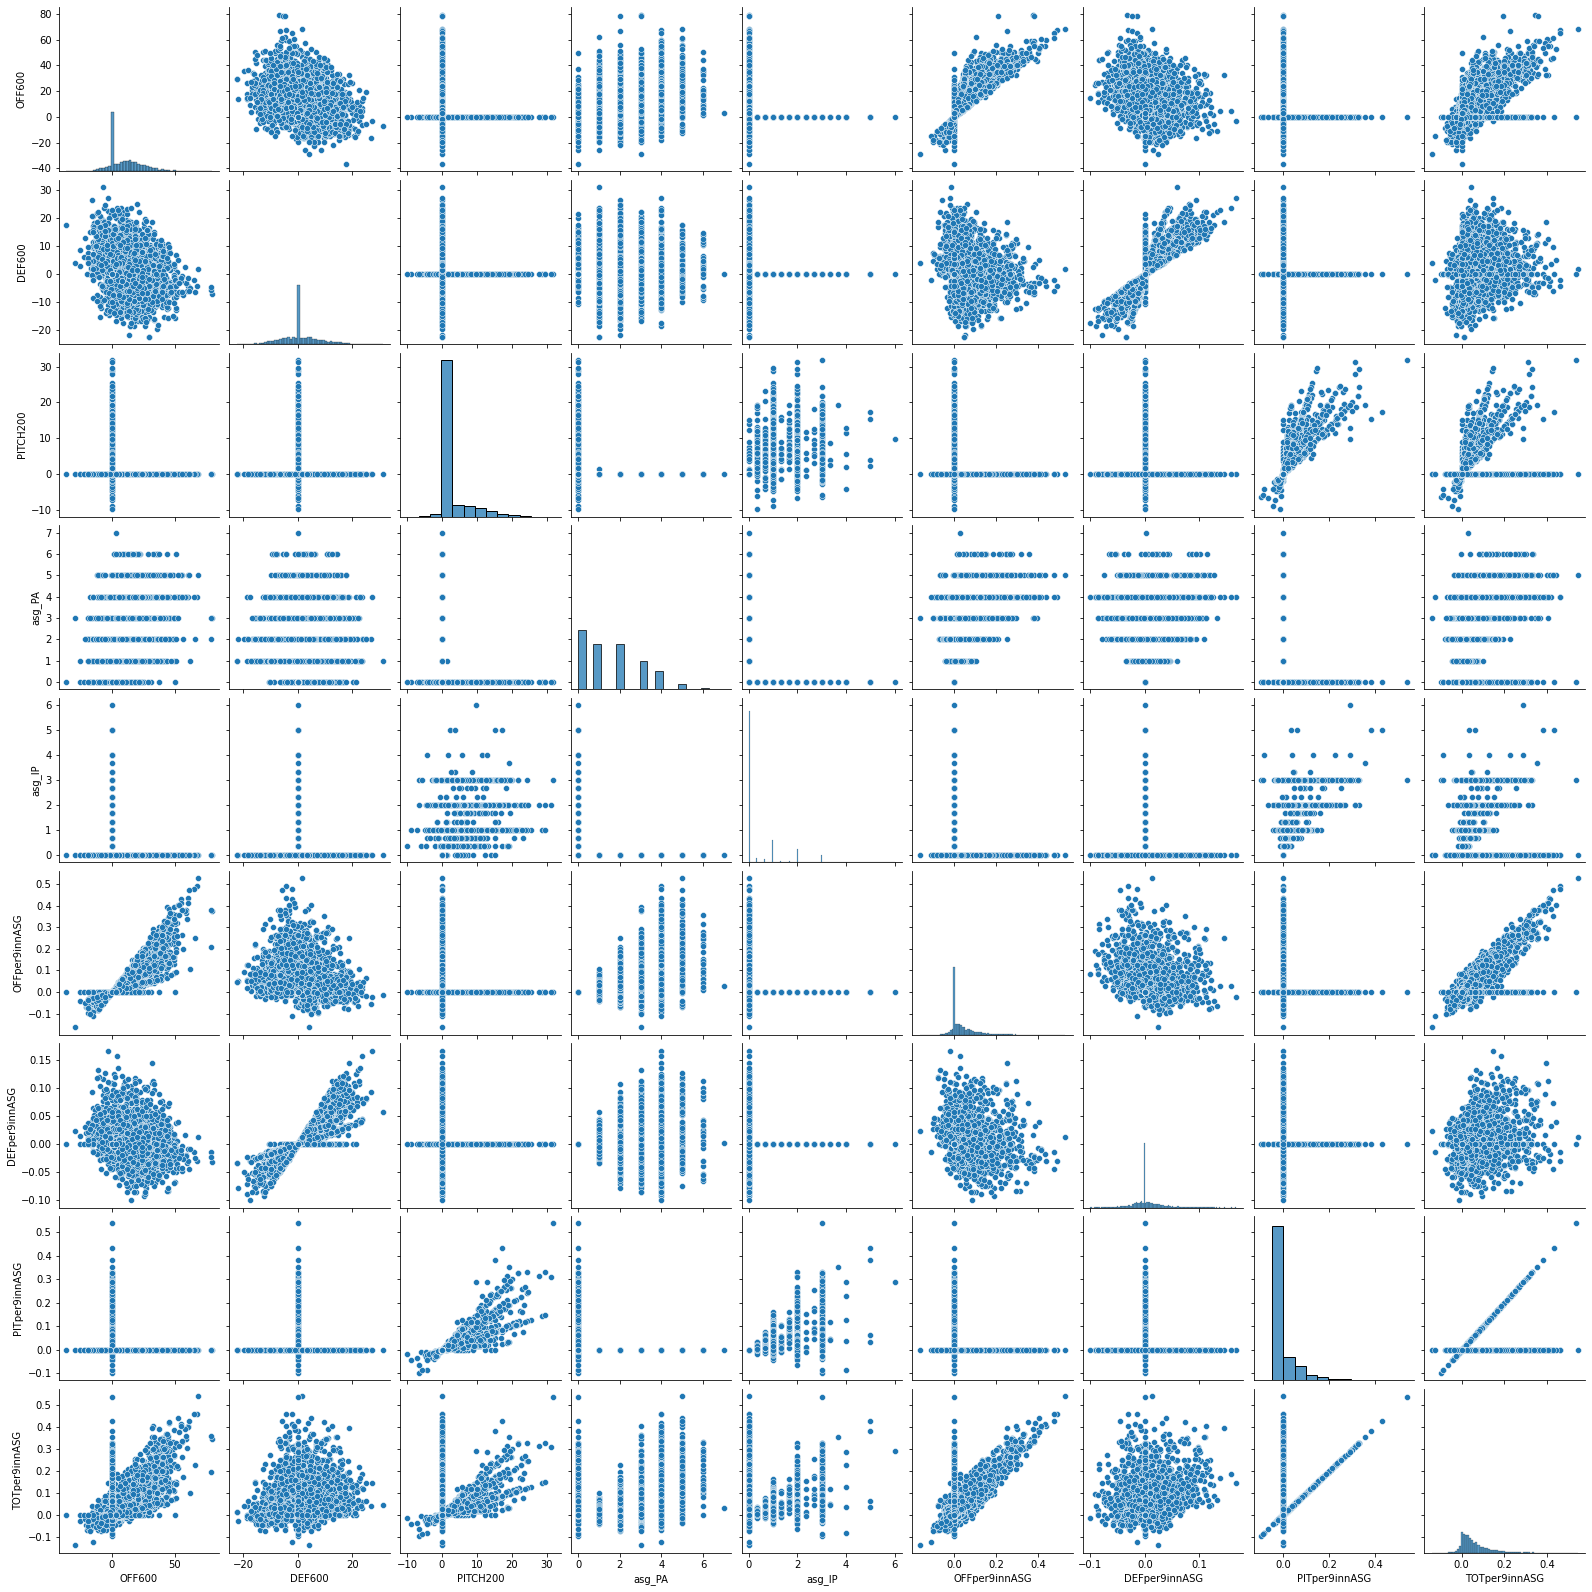

In [36]:
sns.pairplot(data=all_stars_only_quantitative_variables)